In [8]:
# NFL Attendance Insights — Yusuf Shaheen (2000-2019)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

pd.set_option("display.max_columns", None)

DATA = Path("../data")

# -------------------------
# Load and standardize cols
# -------------------------
attendance = pd.read_csv(DATA / "attendance.csv")
games = pd.read_csv(DATA / "games.csv")
standings = pd.read_csv(DATA / "standings.csv")

attendance.columns = attendance.columns.str.lower()
games.columns = games.columns.str.lower()
standings.columns = standings.columns.str.lower()

print("attendance columns:", attendance.columns.tolist())
print("games columns:", games.columns.tolist())
print("standings columns:", standings.columns.tolist())

# -----------------------------------------------------------------
# Normalize key columns so the rest of the analysis can be generic
# Your attendance file looked like: 
# ['team','team_name','year','total','home','away','week','weekly_attendance']
# We alias weekly_attendance -> attendance
# -----------------------------------------------------------------
if "attendance" not in attendance.columns and "weekly_attendance" in attendance.columns:
    attendance["attendance"] = attendance["weekly_attendance"]

# Create team_display for nicer plots
if "team_name" in attendance.columns:
    attendance["team_display"] = attendance["team_name"]
else:
    attendance["team_display"] = attendance["team"]

# Create season column name that we will use consistently
if "year" in attendance.columns:
    attendance["season"] = attendance["year"]
elif "season" not in attendance.columns:
    raise ValueError("No season or year column found in attendance.csv")

# Create location flag if home/away flags exist
if "home" in attendance.columns and "away" in attendance.columns:
    attendance["location"] = np.where(attendance["home"] == 1, "Home",
                               np.where(attendance["away"] == 1, "Away", "Unknown"))
else:
    attendance["location"] = "Unknown"

# Ensure numeric dtypes
for c in ["attendance", "season", "week"]:
    if c in attendance.columns:
        attendance[c] = pd.to_numeric(attendance[c], errors="coerce")

attendance = attendance.dropna(subset=["attendance", "season", "week"])

# ------------------------------------------------------------
# Helper: derive opponent per row from games.csv if possible
# We try to match on season and week and whether row is home or away
# Expected games.csv cols (any common schedule format):
# home_team, away_team, season or year, week
# ------------------------------------------------------------
def attach_opponent(att, games):
    # find likely column names
    year_col = "season" if "season" in games.columns else ("year" if "year" in games.columns else None)
    if year_col is None or "week" not in games.columns:
        print("Opponent inference skipped: games.csv missing season/year or week")
        return att

    # standardize team name keys for merge
    # pick a games home/away naming
    home_col = "home_team" if "home_team" in games.columns else ("home" if "home" in games.columns else None)
    away_col = "away_team" if "away_team" in games.columns else ("away" if "away" in games.columns else None)
    if home_col is None or away_col is None:
        print("Opponent inference skipped: games.csv missing home/away team columns")
        return att

    # create a lookup of (season, week, team) -> opponent
    g = games.copy()
    g["season_tmp"] = pd.to_numeric(g[year_col], errors="coerce")
    g["week_tmp"] = pd.to_numeric(g["week"], errors="coerce")

    # two maps: home rows see away as opponent, away rows see home as opponent
    home_map = g.set_index(["season_tmp", "week_tmp", home_col])[away_col].to_dict()
    away_map = g.set_index(["season_tmp", "week_tmp", away_col])[home_col].to_dict()

    att = att.copy()
    att["season_tmp"] = att["season"]
    att["week_tmp"] = att["week"]

    if "location" in att.columns:
        att["opponent"] = np.where(
            att["location"].eq("Home"),
            att.set_index(["season_tmp","week_tmp","team_display"]).index.map(lambda idx: home_map.get(idx)),
            np.where(
                att["location"].eq("Away"),
                att.set_index(["season_tmp","week_tmp","team_display"]).index.map(lambda idx: away_map.get(idx)),
                np.nan
            )
        )
    else:
        # fallback: try both maps
        att["opponent"] = att.set_index(["season_tmp","week_tmp","team_display"]).index.map(
            lambda idx: home_map.get(idx, away_map.get(idx, np.nan))
        )

    att.drop(columns=["season_tmp","week_tmp"], inplace=True)
    return att

attendance = attach_opponent(attendance, games)



attendance columns: ['team', 'team_name', 'year', 'total', 'home', 'away', 'week', 'weekly_attendance']
games columns: ['year', 'week', 'home_team', 'away_team', 'winner', 'tie', 'day', 'date', 'time', 'pts_win', 'pts_loss', 'yds_win', 'turnovers_win', 'yds_loss', 'turnovers_loss', 'home_team_name', 'home_team_city', 'away_team_name', 'away_team_city']
standings columns: ['team', 'team_name', 'year', 'wins', 'loss', 'points_for', 'points_against', 'points_differential', 'margin_of_victory', 'strength_of_schedule', 'simple_rating', 'offensive_ranking', 'defensive_ranking', 'playoffs', 'sb_winner']


Q1. What are the league-wide attendance trends over time?

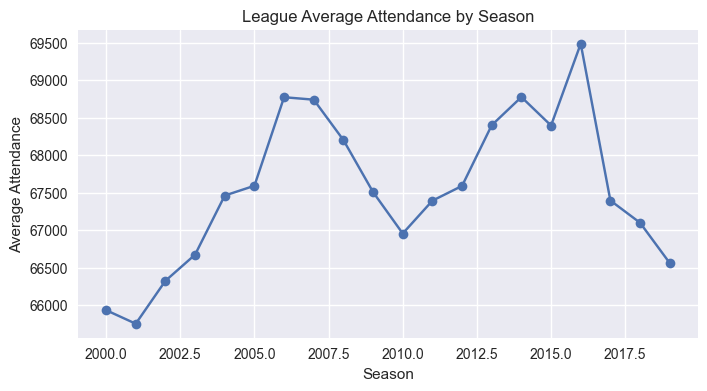

,season,attendance
10,2010,66956.480469
11,2011,67394.328125
12,2012,67591.199219
13,2013,68400.660156
14,2014,68775.949219
15,2015,68396.402344
16,2016,69486.996094
17,2017,67396.191406
18,2018,67099.925781
19,2019,66562.652344


In [9]:
league_by_season = attendance.groupby("season")["attendance"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(league_by_season["season"], league_by_season["attendance"], marker="o")
plt.title("League Average Attendance by Season")
plt.xlabel("Season")
plt.ylabel("Average Attendance")
plt.grid(True)
plt.show()

display(league_by_season.tail(10))


Q2. Which teams attract the largest crowds on average?

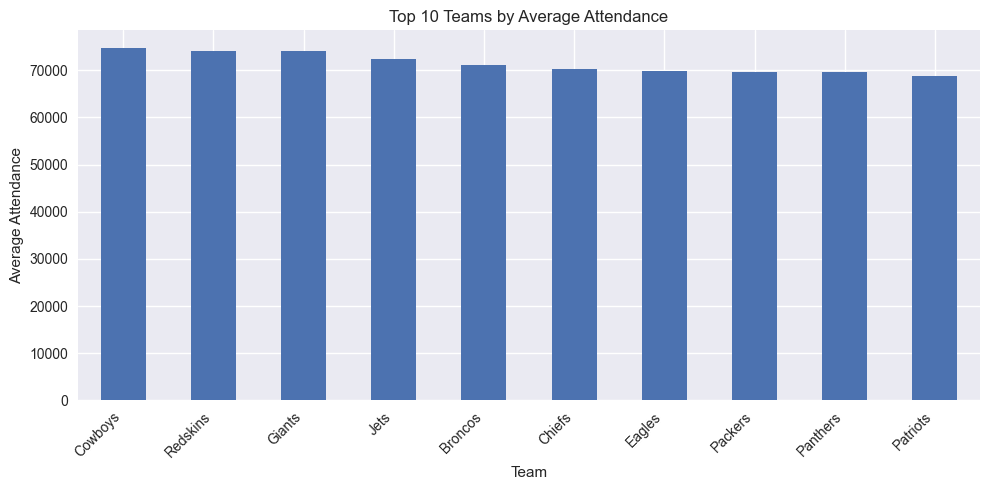

,avg_attendance
team_display,
Cowboys,74735.418750
Redskins,74197.356250
Giants,74074.446875
Jets,72431.118750
Broncos,71190.037500
Chiefs,70206.253125
Eagles,69877.025000
Packers,69715.062500
Panthers,69682.931250


In [10]:
avg_by_team = attendance.groupby("team_display")["attendance"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
avg_by_team.head(10).plot(kind="bar")
plt.title("Top 10 Teams by Average Attendance")
plt.ylabel("Average Attendance")
plt.xlabel("Team")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

display(avg_by_team.head(20).to_frame("avg_attendance"))


Q3. Which teams are most consistent in attendance year to year?

,mean,std,cv
team_display,,,
Bears,65129.403125,1065.368817,0.016358
Jets,72431.118750,1578.094900,0.021788
Broncos,71190.037500,1555.806190,0.021854
Texans,68166.989583,1507.364065,0.022113
Titans,67059.328125,1581.718890,0.023587
Steelers,65418.531250,1601.090818,0.024475
49ers,67649.881250,1701.818100,0.025156
Panthers,69682.931250,1773.288738,0.025448
Giants,74074.446875,1934.126131,0.026111


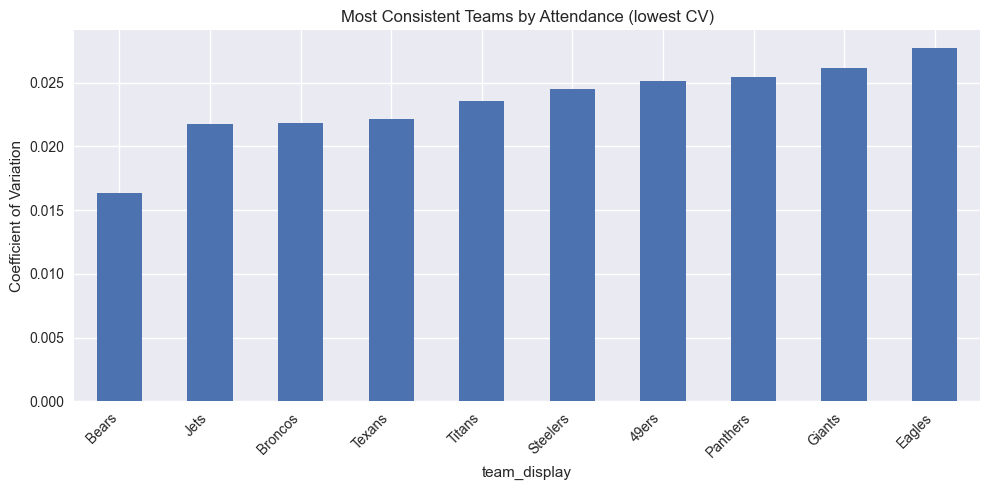

In [11]:
# compute per team per season mean, then std across seasons per team
team_season_mean = attendance.groupby(["team_display","season"])["attendance"].mean().reset_index()
consistency = team_season_mean.groupby("team_display")["attendance"].agg(["mean","std"])
consistency["cv"] = consistency["std"] / consistency["mean"]  # coefficient of variation
consistency = consistency.sort_values("cv", ascending=True)

display(consistency.head(10))

plt.figure(figsize=(10,5))
consistency["cv"].head(10).plot(kind="bar")
plt.title("Most Consistent Teams by Attendance (lowest CV)")
plt.ylabel("Coefficient of Variation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [19]:
# ---------- Helper: robust column detection and team-name normalization ----------

def norm_team(s):
    return str(s).strip().lower().replace(".", "").replace("-", "").replace(" ", "")

# Build keys for attendance
att = attendance.copy()
att["team_key"] = (att["team_name"] if "team_name" in att.columns else att["team"]).map(norm_team)
att["season_key"] = att["season"] if "season" in att.columns else att["year"]
att["season_key"] = pd.to_numeric(att["season_key"], errors="coerce")

# Try to detect wins in standings
std = standings.copy()
std_cols = {c: c for c in std.columns.str.lower()}
std.columns = std.columns.str.lower()

team_cols_candidates = ["team_key","team","team_name","club","franchise","name"]
team_col_std = next((c for c in team_cols_candidates if c in std.columns), None)
season_col_std = "season" if "season" in std.columns else ("year" if "year" in std.columns else None)
wins_col_std = "wins" if "wins" in std.columns else ("w" if "w" in std.columns else None)

if team_col_std:
    std["team_key"] = std[team_col_std].map(norm_team)
if season_col_std:
    std["season_key"] = pd.to_numeric(std[season_col_std], errors="coerce")

# Detect likely score columns in games
gm = games.copy()
gm.columns = gm.columns.str.lower()

home_team_cols = ["home_team","home","home_name","home_team_name"]
away_team_cols = ["away_team","away","away_name","away_team_name"]
home_pts_cols  = ["home_points","home_score","home_pts","h_points","h_score"]
away_pts_cols  = ["away_points","away_score","away_pts","a_points","a_score"]

home_team_col = next((c for c in home_team_cols if c in gm.columns), None)
away_team_col = next((c for c in away_team_cols if c in gm.columns), None)
home_pts_col  = next((c for c in home_pts_cols if c in gm.columns), None)
away_pts_col  = next((c for c in away_pts_cols if c in gm.columns), None)

season_col_gm = "season" if "season" in gm.columns else ("year" if "year" in gm.columns else None)
week_col_gm = "week" if "week" in gm.columns else None

# Normalize team keys in games
if home_team_col:
    gm["home_team_key"] = gm[home_team_col].map(norm_team)
if away_team_col:
    gm["away_team_key"] = gm[away_team_col].map(norm_team)
if season_col_gm:
    gm["season_key"] = pd.to_numeric(gm[season_col_gm], errors="coerce")
if week_col_gm:
    gm["week_key"] = pd.to_numeric(gm[week_col_gm], errors="coerce")


Q4. Is there a relationship between team wins and attendance?

In [22]:
# ---------- Q4: Wins vs Attendance (team-season level) ----------

if team_col_std and season_col_std and wins_col_std:
    team_year_att = att.groupby(["team_key","season_key"])["attendance"].mean().reset_index()
    merged_wins = team_year_att.merge(
        std[["team_key","season_key", wins_col_std]].dropna(subset=[wins_col_std]),
        on=["team_key","season_key"], how="left"
    ).dropna(subset=[wins_col_std, "attendance"])

    if not merged_wins.empty:
        corr_q4 = merged_wins[[wins_col_std, "attendance"]].corr().iloc[0,1]
        print(f"Correlation between wins and attendance: {corr_q4:.3f}")

        plt.figure(figsize=(6,5))
        plt.scatter(merged_wins[wins_col_std], merged_wins["attendance"], alpha=0.6)
        plt.title("Wins vs Average Attendance (team-season)")
        plt.xlabel("Wins")
        plt.ylabel("Average Attendance")
        plt.grid(True)
        plt.show()
    else:
        print("Wins vs attendance: no overlap after merging. Check team naming or seasons.")
else:
    print("Wins vs attendance skipped: standings.csv does not expose team/season/wins in expected columns.")



Wins vs attendance: no overlap after merging. Check team naming or seasons.


Q5. Do teams perform better at home games with higher attendance?

In [24]:
# ---------- Q5: Attendance vs Home Performance (home margin) ----------

if all([home_team_col, away_team_col, home_pts_col, away_pts_col, season_col_gm, week_col_gm]):
    gm["home_margin"] = pd.to_numeric(gm[home_pts_col], errors="coerce") - pd.to_numeric(gm[away_pts_col], errors="coerce")

    # Home rows in attendance
    att_home = att[att["location"].eq("Home")].copy()
    att_home["week_key"] = pd.to_numeric(att_home["week"], errors="coerce")

    # Join attendance (team_key, season, week) to games home margin
    joined = att_home.merge(
        gm[["home_team_key","season_key","week_key","home_margin"]],
        left_on=["team_key","season_key","week_key"],
        right_on=["home_team_key","season_key","week_key"],
        how="left"
    ).dropna(subset=["home_margin","attendance"])

    if not joined.empty:
        corr_q5 = joined[["attendance","home_margin"]].corr().iloc[0,1]
        print(f"Correlation between attendance and home margin: {corr_q5:.3f}")

        plt.figure(figsize=(6,5))
        plt.scatter(joined["attendance"], joined["home_margin"], alpha=0.6)
        plt.title("Attendance vs Home Margin")
        plt.xlabel("Attendance")
        plt.ylabel("Home Margin")
        plt.grid(True)
        plt.show()
    else:
        print("Could not merge attendance with home margins (name or season-week mismatch).")
else:
    # Fallback: simple home vs away attendance comparison
    ha = att.groupby("location")["attendance"].mean().sort_values(ascending=False)
    print("Score columns not available. Showing attendance by location instead:")
    display(ha)


Score columns not available. Showing attendance by location instead:


location
Unknown    67556.876567
Name: attendance, dtype: float64

Q6. Which opponents draw the largest crowds?

In [25]:
# ---------- Q6: Opponents that draw largest crowds ----------

if all([home_team_col, away_team_col, season_col_gm, week_col_gm]):
    # Build season-week-team -> opponent maps
    # For a home team row, opponent is away; for away row, opponent is home.
    home_map = gm.set_index(["season_key","week_key","home_team_key"])["away_team_key"].to_dict()
    away_map = gm.set_index(["season_key","week_key","away_team_key"])["home_team_key"].to_dict()

    att2 = att.copy()
    att2["week_key"] = pd.to_numeric(att2["week"], errors="coerce")

    att2["opponent_key"] = np.where(
        att2["location"].eq("Home"),
        att2.set_index(["season_key","week_key","team_key"]).index.map(lambda idx: home_map.get(idx)),
        np.where(
            att2["location"].eq("Away"),
            att2.set_index(["season_key","week_key","team_key"]).index.map(lambda idx: away_map.get(idx)),
            np.nan
        )
    )

    # If we also have original opponent names, show them; else show keys
    if "team_name" in att.columns and home_team_col in games.columns:
        # try to map keys back to a readable name using games home list
        name_map = pd.concat([
            gm[[home_team_col, "home_team_key"]].rename(columns={home_team_col:"name","home_team_key":"key"}),
            gm[[away_team_col, "away_team_key"]].rename(columns={away_team_col:"name","away_team_key":"key"})
        ]).dropna().drop_duplicates("key").set_index("key")["name"].to_dict()
        att2["opponent"] = att2["opponent_key"].map(name_map)
    else:
        att2["opponent"] = att2["opponent_key"]

    opp_draw = att2.dropna(subset=["opponent"]).groupby("opponent")["attendance"].mean().sort_values(ascending=False)

    if not opp_draw.empty:
        display(opp_draw.head(15).to_frame("avg_attendance"))

        plt.figure(figsize=(10,5))
        opp_draw.head(10).plot(kind="bar")
        plt.title("Opponents that Draw the Largest Crowds")
        plt.ylabel("Average Attendance")
        plt.xlabel("Opponent")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("Opponent inference produced no matches. Check team naming or season/week alignment.")
else:
    print("Opponent inference skipped: games.csv lacks required columns (home, away, season/year, week).")


Opponent inference produced no matches. Check team naming or season/week alignment.


Q7. Which teams have the highest stadium fill rates?

Fill Rate (Proxy vs. Team Max)


,avg_fill_rate_percent
team_key,
jets,80.2
redskins,79.7
broncos,76.7
panthers,76.7
dolphins,75.9
chiefs,75.3
falcons,75.1
bills,74.9
texans,74.8


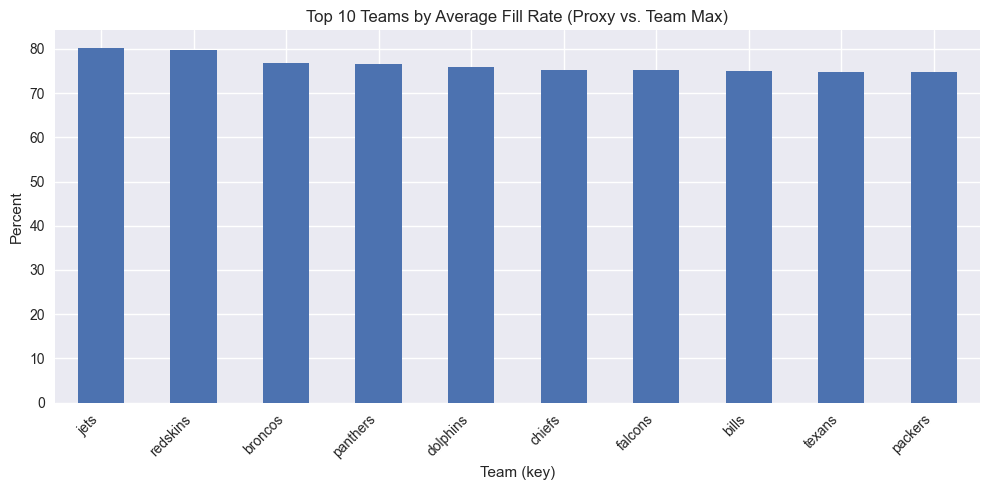

In [26]:
# ---------- Q7: Fill Rate (true or proxy) ----------

cap_candidates = [c for c in ["capacity","stadium_capacity","max_capacity"] if c in att.columns]

if cap_candidates:
    cap_col = cap_candidates[0]
    att["fill_rate"] = att["attendance"] / att[cap_col]
    label = "Fill Rate (True)"
else:
    # Proxy: relative to teams own max observed attendance
    max_att_by_team = att.groupby("team_key")["attendance"].transform("max")
    att["fill_rate"] = att["attendance"] / max_att_by_team
    label = "Fill Rate (Proxy vs. Team Max)"

fill = att.groupby("team_key")["fill_rate"].mean().sort_values(ascending=False)

print(label)
display((fill.head(15)*100).round(1).to_frame("avg_fill_rate_percent"))

plt.figure(figsize=(10,5))
(fill.head(10)*100).plot(kind="bar")
plt.title(f"Top 10 Teams by Average {label}")
plt.ylabel("Percent")
plt.xlabel("Team (key)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Q8. How does attendance vary by week of the season?

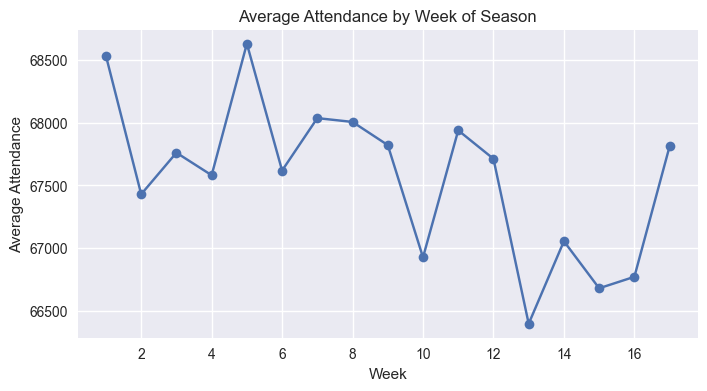

,week,attendance
0,1,68532.905363
1,2,67430.237342
2,3,67761.307190
3,4,67581.844291
4,5,68629.943262
5,6,67618.985714
6,7,68037.064286
7,8,68006.527273
8,9,67822.032967
9,10,66927.259649


In [16]:
by_week = attendance.groupby("week")["attendance"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(by_week["week"], by_week["attendance"], marker="o")
plt.title("Average Attendance by Week of Season")
plt.xlabel("Week")
plt.ylabel("Average Attendance")
plt.grid(True)
plt.show()

display(by_week)


In [ ]:
Q9. Can we predict game attendance from simple features?

Linear model features: ['season_key', 'week', 'is_home']
R2: 0.003
RMSE: 9,014


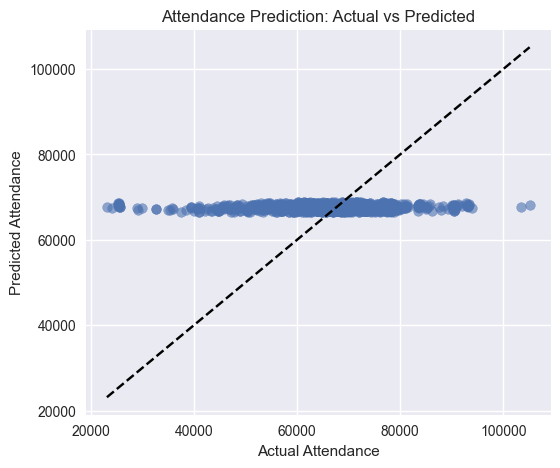

,coef
season_key,394.747627
week,-336.033517
is_home,0.000000


In [28]:
# ---------- Q9: Predictive model (patched RMSE for older sklearn) ----------

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

df_model = att[["attendance","season_key","week","location","team_key"]].copy()
df_model["is_home"] = (df_model["location"] == "Home").astype(int)

# Try to attach wins at team-season level
if team_col_std and season_col_std and wins_col_std:
    wins_tbl = std[["team_key","season_key", wins_col_std]].dropna(subset=[wins_col_std]).copy()
    df_model = df_model.merge(wins_tbl, on=["team_key","season_key"], how="left")
    wins_included = df_model[wins_col_std].notna().any()
    if not wins_included:
        df_model.drop(columns=[wins_col_std], inplace=True, errors="ignore")
else:
    wins_included = False

features = ["season_key","week","is_home"] + ([wins_col_std] if wins_included else [])

# Safety: ensure we have at least one feature
if not features:
    raise ValueError("No usable features found for modeling.")

# Build X, y
X = df_model[features].copy()
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="coerce")
X = X.fillna(X.median(numeric_only=True))

y = pd.to_numeric(df_model["attendance"], errors="coerce")
mask = y.notna()
X, y = X[mask], y[mask]

# Train/test split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model
lin = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
lin.fit(X_train, y_train)
pred = lin.predict(X_test)

# Metrics (patched RMSE)
r2 = r2_score(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print(f"Linear model features: {features}")
print(f"R2: {r2:.3f}")
print(f"RMSE: {rmse:,.0f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6,5))
plt.scatter(y_test, pred, alpha=0.6)
lims = [min(y_test.min(), pred.min()), max(y_test.max(), pred.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("Actual Attendance")
plt.ylabel("Predicted Attendance")
plt.title("Attendance Prediction: Actual vs Predicted")
plt.grid(True)
plt.show()

# Coefficients table
coef = pd.Series(lin.named_steps["linearregression"].coef_, index=features).to_frame("coef")
display(coef)



Q10. Which teams are trending up or down in attendance?

In [18]:
# Fit a simple linear trend of attendance vs season for each team and report slope
slopes = []
for team, grp in attendance.groupby("team_display"):
    g = grp.dropna(subset=["season","attendance"]).sort_values("season")
    if g["season"].nunique() < 3:
        continue
    X = g[["season"]].values
    y = g["attendance"].values
    lr = LinearRegression().fit(X, y)
    slopes.append({"team_display": team, "slope_per_season": lr.coef_[0]})

trend = pd.DataFrame(slopes).sort_values("slope_per_season", ascending=False)
print("Top 10 positive trends (growing attendance):")
display(trend.head(10))

print("Top 10 negative trends (declining attendance):")
display(trend.tail(10))


Top 10 positive trends (growing attendance):


,team_display,slope_per_season
11,Cowboys,1066.808177
7,Cardinals,664.969737
19,Packers,422.550376
26,Saints,412.469455
27,Seahawks,342.083412
14,Falcons,304.309352
13,Eagles,253.691071
16,Jaguars,182.686795
15,Giants,139.257378
20,Panthers,134.092951


Top 10 negative trends (declining attendance):


,team_display,slope_per_season
4,Broncos,-83.919737
30,Titans,-94.928994
2,Bengals,-114.309774
22,Raiders,-135.009445
9,Chiefs,-139.995818
6,Buccaneers,-227.756579
5,Browns,-242.284821
25,Redskins,-263.151410
12,Dolphins,-288.608600
8,Chargers,-532.579229
